In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_csv = pd.read_csv('german.data.txt', delim_whitespace=True, header=None)

In [3]:
data_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
Xdf = data_csv.ix[:, data_csv.columns != 20]
print(Xdf.shape)
ydf = data_csv.ix[:, data_csv.columns == 20]
print(ydf.shape)

(1000, 20)
(1000, 1)


In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [7]:
label_encoder = LabelEncoder()

In [8]:
categorial_inds = [0, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 18, 19]

In [9]:
Xdf_labeled = Xdf.copy()
for i in categorial_inds:
    Xdf_labeled[i] = label_encoder.fit_transform(Xdf_labeled[i])

In [10]:
Xdf_labeled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,6,4,4,1169,4,4,4,2,0,3,0,67,2,1,2,2,1,1,0
1,1,48,2,4,5951,0,2,2,1,0,1,0,22,2,1,1,2,1,0,0
2,3,12,4,7,2096,0,3,2,2,0,2,0,49,2,1,1,1,2,0,0
3,0,42,2,3,7882,0,3,2,2,2,3,1,45,2,2,1,2,2,0,0
4,0,24,3,0,4870,0,2,3,2,0,3,3,53,2,2,2,2,2,0,0


In [11]:
onehot_encoder = OneHotEncoder(categorical_features=categorial_inds, sparse=False)

In [12]:
X_labeled = Xdf_labeled.values
X_onehot = onehot_encoder.fit_transform(Xdf_labeled.copy().values)
y = ydf.values

In [13]:
yl, yh = y.shape
y = y.reshape(yl,)

In [14]:
def tree_fit_and_export_graphviz(est, X, y, filename):
    est.fit(X, y)
    tree.export_graphviz(est, filename)

In [15]:
tree_fit_and_export_graphviz(tree.DecisionTreeClassifier(), X_labeled, y, '4. tree-on-labeled.dot')

In [16]:
tree_fit_and_export_graphviz(tree.DecisionTreeClassifier(), X_onehot, y, '4. tree-on-onehot.dot')

Можно посмотреть на первые три деления для '4. tree-on-labeled.dot'
1. X[0] <= 1.5 - состояние счета клиента, A11 A12 - счет есть, накоплений не слишком много
2. X[1] <= 22.5 - срок кредита в месяцах
3. X[13] <= 1.5 - есть информация о рассрочках/кредитах клиента (?)

...

Для '4. tree-on-onehot.dot' эти пункты идентичны, только идентифицировать их сложнее

In [17]:
X_lb_train, X_lb_test, y_lb_train, y_lb_test = train_test_split(X_labeled, y, train_size=0.7, random_state=321)

In [18]:
X_oh_train, X_oh_test, y_oh_train, y_oh_test = train_test_split(X_onehot, y, train_size=0.7, random_state=123)

In [19]:
def test(est, x_train, x_test, y_train, y_test):
    est.fit(x_train, y_train)
    print('train_score:', accuracy_score(est.predict(x_train), y_train))
    print(' test_score:', accuracy_score(est.predict(x_test ), y_test ))

In [20]:
test(tree.DecisionTreeClassifier(), X_lb_train, X_lb_test, y_lb_train, y_lb_test)

train_score: 1.0
 test_score: 0.67


In [21]:
test(tree.DecisionTreeClassifier(), X_oh_train, X_oh_test, y_oh_train, y_oh_test)

train_score: 1.0
 test_score: 0.663333333333


### Optimize depth of tree

In [22]:
depths = range(1, 30)

In [23]:
lb_scores_cv = []
lb_scores_train = []
oh_scores_cv = []
oh_scores_train = []
for d in depths:
    lb_scores_cv.append(np.mean(cross_val_score(tree.DecisionTreeClassifier(max_depth=d), X_labeled, y, cv=5)))
    est_lb = tree.DecisionTreeClassifier(max_depth=d)
    est_lb.fit(X_lb_train, y_lb_train)
    lb_scores_train.append(accuracy_score(est_lb.predict(X_lb_train), y_lb_train))
    oh_scores_cv.append(np.mean(cross_val_score(tree.DecisionTreeClassifier(max_depth=d), X_onehot , y, cv=5)))
    est_oh = tree.DecisionTreeClassifier(max_depth=d)
    est_oh.fit(X_oh_train, y_oh_train)
    oh_scores_train.append(accuracy_score(est_oh.predict(X_oh_train), y_oh_train))

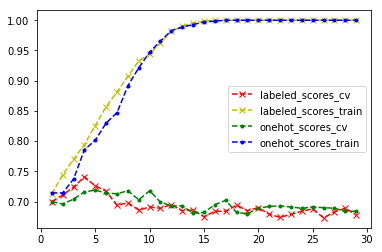

In [24]:
plt.plot(depths, lb_scores_cv   , 'x--r')
plt.plot(depths, lb_scores_train, 'x--y')
plt.plot(depths, oh_scores_cv   , '.--g')
plt.plot(depths, oh_scores_train, '.--b')
plt.legend(['labeled_scores_cv', 'labeled_scores_train', 'onehot_scores_cv', 'onehot_scores_train'])
plt.show()

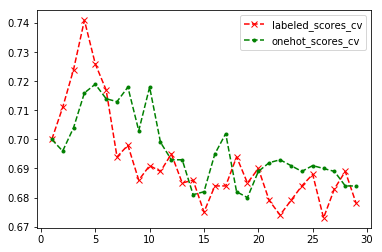

In [25]:
plt.plot(depths, lb_scores_cv   , 'x--r')
plt.plot(depths, oh_scores_cv   , '.--g')
plt.legend(['labeled_scores_cv', 'onehot_scores_cv'])
plt.show()

In [26]:
tree_fit_and_export_graphviz(tree.DecisionTreeClassifier(max_depth=4), X_labeled, y, '4. tree-on-labeled-d=4.dot')

In [27]:
tree_fit_and_export_graphviz(tree.DecisionTreeClassifier(max_depth=5), X_onehot, y, '4. tree-on-onehot-d=5.dot')